# Computational and Variational Methods for Inverse Problems

## Assignment 2: Optimization methods and automatic differentiation

### (Notebook outline for problems 2, 3, and 4)

### Your name: Mohammad Afzal Shadab

## Dependencies:

 - numpy
 - scipy
 - matplotlib
 - autograd (https://github.com/HIPS/autograd)

In [1]:
!conda install --yes autograd
import autograd.numpy as np
from autograd import grad, jacobian

import matplotlib.pyplot as plt
from scipy import optimize

Solving environment: done

# All requested packages already installed.



# 2) Discretized length and energy functionals

In this problem you will write code to compute the length functional $L(u)$ and energy functional $E(u)$ from problem 1, for continuous piecewise linear functions $u:[0,1]\rightarrow \mathbb{R}$ with equally spaced nodes. We assume that $u$ has $N+2$ equally spaced nodes at locations
$$0, h, 2h, 3h, \dots, Nh, 1$$
and that $u$ takes specified values at the nodes, and is piecewise linear in the intervals ("cells") between these nodes.

## 2a) Spatial derivative of piecewise linear function
Let $u(x)$ be a continuous piecewise linear function on $[0,1]$, with $N+2$ equally spaced nodes (including endpoints). The spatial derivative $\frac{du}{dx}$ is piecewise constant on the $N+1$ cells between neighboring nodes. An example of this is shown below.

Text(0.5, 1.0, 'du/dx')

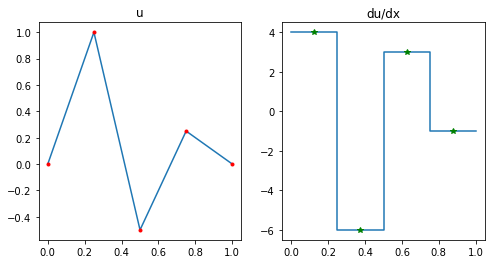

In [2]:
nodes = np.linspace(0.0, 1.0, 5)
u_at_nodes = np.array([0.0, 1.0, -0.5, 0.25, 0.0])

cell_centers = 0.5 * (nodes[1:] + nodes[:-1])
du_dx_in_cells = np.array([ 4., -6.,  3., -1.])

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.plot(nodes, u_at_nodes)
plt.plot(nodes, u_at_nodes, '.r')
plt.title('u')

plt.subplot(1,2,2)
plt.plot(nodes, np.concatenate([du_dx_in_cells, [-1]]), drawstyle='steps-post')
plt.plot(cell_centers, du_dx_in_cells, '*g')
plt.title('du/dx')

### Your task:
Write a function called "spatial\_derivative" that takes the length-$(N+2)$ vector of nodal values for $u$ as input, and returns the length-$N+1$ vector of cell values of $\frac{du}{dx}$ as output.

In [3]:
def spatial_derivative(u_at_nodes):
    
    dx = 1/(len(u_at_nodes) - 1) # Cell width = L/(N+1) = L/((N+2)-1)
    
    du_dx_in_cells = (u_at_nodes[1:] - u_at_nodes[:-1])/dx

    return du_dx_in_cells

### Test:
Error should be close to machine epsilon (around $10^{-14}$ or smaller)

In [4]:
u = np.array([0.25, -0.66,  0.70, -0.41, -1.02, 0.57,  0.13, -1.27,  0.83, -1.21])
du_dx_true = np.array([-8.19,  12.24,  -9.99,  -5.49,  14.31,  -3.96, -12.6,  18.9, -18.36])

du_dx = spatial_derivative(u)
spatial_derivative_error = np.linalg.norm(du_dx - du_dx_true)
print('spatial_derivative_error=', spatial_derivative_error)

spatial_derivative_error= 5.7044291861996796e-15


## 2b) Arc length function

In Problem 1 you showed that the arc length of a function $u:[0,1]\rightarrow \mathbb{R}$ is given by
$$L(u) = \int_0^1 \sqrt{1 + \left(\frac{du}{dx}(x)\right)^2}  dx$$

### Your task:
Let $u$ be a continuous piecewise linear function on $[0,1]$, with $N+2$ equally spaced nodes, including endpoints (the same setup as in 2a). Write a function called "length\_functional" that takes the vector of $N+2$ nodal values of $u$ as input, and returns the arc length of $u$ as output.

#### Hint:
The integrand is a piecewise constant function.

In [5]:
def length_functional(u_at_nodes):
    dx = 1/(len(u_at_nodes) - 1) # Cell width = L/(N+1) = L/((N+2)-1)
    spat_der = spatial_derivative(u_at_nodes)
    L = sum(np.sqrt(1 + spat_der**2)*dx)
    return L

### Test
Error should be close to machine epsilon (around $10^{-14}$ or smaller)

In [6]:
xx = np.linspace(0.0, 1.0, 100)
u = np.sqrt(1.0 / 2.0 - np.power(xx - 0.5, 2))
L_true = 1.1107087105088733

L = length_functional(u)
length_functional_error = np.abs(L - L_true)
print('length_functional_error=', length_functional_error)

length_functional_error= 6.661338147750939e-16


## 2c) Energy functional

Let $u$ be the height of an idealized hanging chain, and for convenience let the linear density of the chain be $\rho=1/g$, where the $g$ is the gravitational constant. From Problem 1 we know that the potential energy functional for such a hanging chain is given by
$$E(u) = \int_0^1 u(x) \sqrt{1 + \left(\frac{du}{dx}(x)\right)^2}  dx.$$

### Your task
Write a function named "energy\_functional" that takes as input the length $N+2$ vector of nodal values for a continuous piecewise linear function $u$ on $[0,1]$ as input (including values at the endpoints, as in 2a and 2b), and returns the energy functional $E(u)$ as output.

#### Hint:
The integrand is a **discontinuous** piecewise linear function because it is the product of a continuous piecewise linear function with a piecewise constant function.

In [7]:
def energy_functional(u_at_nodes):

    dx = 1/(len(u_at_nodes) - 1) # Cell width = L/(N+1) = L/((N+2)-1)
    spat_der = spatial_derivative(u_at_nodes)
    E = sum(0.5*(u_at_nodes[1:] + u_at_nodes[:-1])*np.sqrt(1 + spat_der**2)*dx)
    
    return E

### Test
Error should be close to machine epsilon (around $10^{-14}$ or smaller)

In [8]:
xx = np.linspace(0.0, 1.0, 75)
u = -np.sin(np.pi * xx)
E_true = -1.2379425688273515

E = energy_functional(u)
energy_functional_error = np.abs(E - E_true)
print('energy_functional_error=', energy_functional_error)

energy_functional_error= 2.220446049250313e-16


# 3)  Objective function, Gradient, and Hessian

In problem 1 we saw that the hanging chain problem may be written as the following constrained optimization problem:

\begin{align}
\min_u &\quad E(u) \\
\text{such that} &\quad L(u) = L_0.
\end{align}

We may find approximate solutions to this problem by solving the following unconstrained optimization problem,
$$\min_u E(u) + \alpha (L(u) - L_0)^2$$
where we use a quadratic penalty to approximately enforce the constraint. Here $\alpha > 0$ is a penalty parameter; as $\alpha \rightarrow \infty$, the solution to the unconstrained optimization problem approaches the solution of the constrained optimization problem.

Let
$$J(u) := E(u) + \alpha (L(u) - L_0)^2$$
denote the unconstrained objective function. In this problem, you will implement this objective function for continuous piecewise linear functions with equally spaced nodes, and use **automatic differentiation** to compute the gradient of $J$, the Hessian of $J$, and matrix-vector products of the Hessian of $J$ with arbitrary vectors. You will also compare the gradient and Hessian of $J$ to approximate gradients and Hessians computed with finite differences with a variety of step sizes.

## Objective function
The objective function may be written as follows, using your energy and length functional code from the previous problem. Note that the objective function only operates on the $N$ interior nodes for $u$, since the endpoints of $u$ are fixed at zero.

In [9]:
def objective_function(u_at_interior_nodes, alpha, L0):
    u_at_nodes = np.hstack([np.array([0.0]),
                                     u_at_interior_nodes,
                                     np.array([0.0])])
    
    E = energy_functional(u_at_nodes)
    L = length_functional(u_at_nodes)
    J = E + alpha * np.power(L - L0, 2)
    return J

If you were unable to complete the previous problem, you may uncomment the following (intentionally obfsucated) implementation and use it instead:

In [10]:
# def objective_function(u_at_interior_vertices, alpha, L0):
#     u = np.concatenate([np.array([0]),
#                         u_at_interior_vertices,
#                         np.array([0])])
#     a = 1./(len(u)-1.)
#     b, c = (u[1:]-u[:-1])/a, 0.5*(u[1:] + u[:-1])
#     return a*np.sum(c*np.sqrt(1.+np.power(b,2)))+alpha*np.power(a*np.sum(np.sqrt(1.+np.power(b,2)))-L0,2)

## 3a) Gradient via automatic differentiation

Here we will use the "grad" function in the python automatic differentiation tool **autograd** to compute the gradient of your objective function. Here is a quick example of how to use it. More details can be found here:
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md

### autodiff grad example

In [11]:
def f(x, a, b):
    return np.cos(a * x[0]) + np.sin(b * x[1])

grad_autodiff = grad(f, 0) # 0 indicates differentiation w.r.t. the first argument of f.

x = np.random.randn(2)
a = 1.3
b = -2.1
grad_at_x_autodiff = grad_autodiff(x, a, b)

grad_at_x_analytic = np.array([- a * np.sin(a * x[0]), 
                                 b * np.cos(b * x[1])])

autodiff_error = np.linalg.norm(grad_at_x_analytic - grad_at_x_autodiff)
print('autodiff_error=', autodiff_error)

autodiff_error= 0.0


### Your task:
Use automatic differentiation to create a function named "compute\_gradient" that computes the gradient of the objective function, $g$, at a given $u$ for a given penalty parameter $\alpha$ and chain length $L_0$.

### Hint:
The code is a one-liner

In [12]:
# Construct the function compute_gradient(u_at_interior_nodes, alpha, L0)
def compute_gradient(u_at_interior_nodes, alpha, L0):
    grad_autodiff = grad(objective_function, 0)
    return grad_autodiff(u_at_interior_nodes, alpha, L0)

### Finite difference check:
On one hand, the directional derivative of $J$ in direction $p$ may be computed from the gradient at $u$, $g(u)$, as follows:
$$\frac{d J}{d u}(u) p = g(u)^T p.$$
On the other hand, we may approximate the directional derivative via finite differences
$$\frac{d J}{du}(u) p \approx \frac{J(u + s p) - J(u)}{s}$$
where $s$ is some small scalar.

This allows us to check our gradient by choosing a random direction $p$, and comparing the result of computing $\frac{d J}{d u}(u) p$ in these two different ways. 

The error should be roughly the same order of magnitude as the step size.

In [13]:
N = 53
alpha = 8.95
L0 = 2.13
u1 = np.random.randn(N)
J1 = objective_function(u1, alpha, L0)

p = np.random.randn(N)
s = 1e-7 # step size
u2 = u1 + s*p

J2 = objective_function(u2, alpha, L0)
dJ_du_p_diff = (J2 - J1) / s

g = compute_gradient(u1, alpha, L0)
dJ_du_p = np.dot(g, p)

grad_err = np.abs( (dJ_du_p - dJ_du_p_diff) / dJ_du_p_diff )
print('step size=', s, ', gradient finite difference error=', grad_err)

step size= 1e-07 , gradient finite difference error= 7.875470862771769e-07


## 3b) Gradient finite difference plot

It is good practice to check your gradient with finite difference checks for a wide range of step sizes $s$, and make a log-log plot of the finite difference error as a function of $s$. If your gradient is working correctly, the resulting plot should look like a 'V', where the error decreases linearly from $s=10^0$ until somewhere around $s=10^{-5}$ to $s=10^{-9}$, then goes up again and/or becomes jagged.

### Example finite difference plot

step size= 1.0 , example gradient finite difference error= 0.1869222424524513
step size= 0.1 , example gradient finite difference error= 0.00349093452167874
step size= 0.01 , example gradient finite difference error= 0.00021854333414250828
step size= 0.001 , example gradient finite difference error= 2.055431862674754e-05
step size= 0.0001 , example gradient finite difference error= 2.0424348250662593e-06
step size= 1e-05 , example gradient finite difference error= 2.0412916377206068e-07
step size= 1e-06 , example gradient finite difference error= 2.0369046920227754e-08
step size= 1e-07 , example gradient finite difference error= 1.2950566966906895e-09
step size= 1e-08 , example gradient finite difference error= 7.787795534963471e-09
step size= 1e-09 , example gradient finite difference error= 2.874822313213768e-08
step size= 1e-10 , example gradient finite difference error= 3.7808855372400296e-07
step size= 1e-11 , example gradient finite difference error= 1.0767684826762245e-06
step s

Text(0, 0.5, 'error')

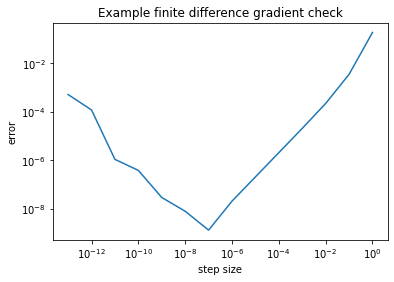

In [14]:
def f(x):
    return np.sin(x[0]) + np.cos(x[1])

def df_dx(x):
    return np.array([np.cos(x[0]), -np.sin(x[1])])

x1 = np.random.randn(2)
p = np.random.randn(2)
step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]

f1 = f(x1)
g1 = df_dx(x1)
df_dx_p = np.dot(g1, p)

grad_errs = list()
for s in step_sizes:
    x2 = x1 + s*p

    f2 = f(x2)
    df_dx_p_diff = (f2 - f1) / s

    grad_err = np.abs( (df_dx_p - df_dx_p_diff) / df_dx_p_diff )
    print('step size=', s, ', example gradient finite difference error=', grad_err)
    
    grad_errs.append(grad_err)

plt.loglog(step_sizes, grad_errs)
plt.title('Example finite difference gradient check')
plt.xlabel('step size')
plt.ylabel('error')

### Your task:
Perform finite difference checks on the hanging chain gradient for a wide range  of step sizes $s$, and make a log-log plot of the finite difference error as a function of $s$. See 3a for an example of a finite difference check for a single step size.

step size= 1.0 , gradient finite difference error= 1.5359221045221785
step size= 0.1 , gradient finite difference error= 0.05048493307123709
step size= 0.01 , gradient finite difference error= 0.011611967825265137
step size= 0.001 , gradient finite difference error= 0.0012955206658956029
step size= 0.0001 , gradient finite difference error= 0.00013085834362065523
step size= 1e-05 , gradient finite difference error= 1.309849323324684e-05
step size= 1e-06 , gradient finite difference error= 1.3085570655726142e-06
step size= 1e-07 , gradient finite difference error= 1.406116058554826e-07
step size= 1e-08 , gradient finite difference error= 4.3438666542285325e-08
step size= 1e-09 , gradient finite difference error= 5.666777934707982e-07
step size= 1e-10 , gradient finite difference error= 1.0271735177357446e-05
step size= 1e-11 , gradient finite difference error= 0.00024019298180859812
step size= 1e-12 , gradient finite difference error= 0.00013358885413378176
step size= 1e-13 , gradient f

Text(0, 0.5, 'error')

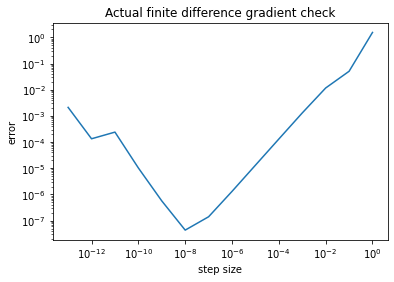

In [15]:
N = 53
alpha = 8.95
L0 = 2.13
u1 = np.random.randn(N)
p = np.random.randn(N)
step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]


# Make log-log plot of gradient finite difference error vs. step size
grad_errs = list()
for s in step_sizes:
    J1 = objective_function(u1, alpha, L0)
    u2 = u1 + s*p

    J2 = objective_function(u2, alpha, L0)
    dJ_du_p_diff = (J2 - J1) / s

    g = compute_gradient(u1, alpha, L0)
    dJ_du_p = np.dot(g, p)

    grad_err = np.abs( (dJ_du_p - dJ_du_p_diff) / dJ_du_p_diff )
    print('step size=', s, ', gradient finite difference error=', grad_err)

    grad_errs.append(grad_err)

plt.loglog(step_sizes, grad_errs)
plt.title('Actual finite difference gradient check')
plt.xlabel('step size')
plt.ylabel('error')

## 3c) Hessian-vector product via automatic differentiation

The Hessian is the derivative of the gradient, so the matrix-vector multiplication $H(u)p$ of the Hessian at $u$, $H(u)$, with a vector, $p$ is given by
$$H(u)p = \frac{d}{du} \left(\frac{d J}{du}(u) p\right) = \frac{d}{du} \left(g(u)^T p\right).$$
In other words, $H(u) p$ is the gradient of the scalar-valued function
$$q(u) := g(u)^T p,$$
and this gradient may be calculated by automatic differentiation.

### Example:

In [16]:
def f(x, a, b):
    return np.cos(a * x[0]) + np.sin(b * x[1])

compute_grad_f = grad(f, 0)

def q(x, p, a, b):
    g = compute_grad_f(x, a, b)
    return np.dot(g, p)

hessian_vector_product_f = grad(q, 0)

a = 1.4
b = 4.1
x = np.random.randn(2)
p = np.random.randn(2)

Hp_autodiff = hessian_vector_product_f(x, p, a, b)

H_analytic = np.array([[-a*a*np.cos(a * x[0]),                     0],
                       [0,                     -b*b*np.sin(b * x[1])]])

Hp_analytic = np.dot(H_analytic, p)

hess_prod_err = np.linalg.norm(Hp_analytic - Hp_autodiff) / np.linalg.norm(Hp_analytic)
print('example hessian vector product error=', hess_prod_err)

example hessian vector product error= 1.6136414068954485e-17


### Your task:
Use autodiff's grad function to create a function named "compute\_hessian\_vector\_product" that computes the Hessian-vector product $H(u)p$.

In [17]:
# Construct the function compute_hessian_vector_product(u_at_interior_nodes, p_at_interior_nodes, alpha, L0)

def compute_hessian_vector_product(u_at_interior_nodes, p_at_interior_nodes, alpha, L0):
    
    def compute_q(u_at_interior_nodes, p_at_interior_nodes, alpha, L0):
    
        return np.dot(compute_gradient(u_at_interior_nodes, alpha, L0), p_at_interior_nodes)
    
    hessian_vector_product = grad(compute_q, 0)
    
    return hessian_vector_product(u_at_interior_nodes, p_at_interior_nodes, alpha, L0)

### Finite difference check
The error should be roughly the same order of magnitude as the step size.

In [18]:
N = 53
alpha = 8.95
L0 = 2.13
u1 = np.random.randn(N)
G1 = compute_gradient(u1, alpha, L0)

p = np.random.randn(N)
s = 1e-7
u2 = u1 + s * p
G2 = compute_gradient(u2, alpha, L0)

Hp_diff = (G2 - G1) / s

Hp = compute_hessian_vector_product(u1, p, alpha, L0)

hessian_vector_product_error = np.linalg.norm(Hp - Hp_diff) / np.linalg.norm(Hp_diff)

print('s=', s, ', hessian vector product finite difference error=', hessian_vector_product_error)

s= 1e-07 , hessian vector product finite difference error= 1.6587773772162207e-06


## 3d) Hessian-vector product finite difference check plot

### Your task:
Construct a log-log plot of the Hessian finite difference error for a wide range of step sizes.

step size= 1.0 , Hessian vector product finite difference error= 1.4733264942668998
step size= 0.1 , Hessian vector product finite difference error= 0.6346241309628482
step size= 0.01 , Hessian vector product finite difference error= 0.5139721052617849
step size= 0.001 , Hessian vector product finite difference error= 0.052443872206184176
step size= 0.0001 , Hessian vector product finite difference error= 0.005252524457037228
step size= 1e-05 , Hessian vector product finite difference error= 0.0005253373249476569
step size= 1e-06 , Hessian vector product finite difference error= 5.2534585137139e-05
step size= 1e-07 , Hessian vector product finite difference error= 5.253690801857948e-06
step size= 1e-08 , Hessian vector product finite difference error= 5.27649027501531e-07
step size= 1e-09 , Hessian vector product finite difference error= 1.681720222985377e-07
step size= 1e-10 , Hessian vector product finite difference error= 2.2173519665320995e-06
step size= 1e-11 , Hessian vector prod

Text(0, 0.5, 'error')

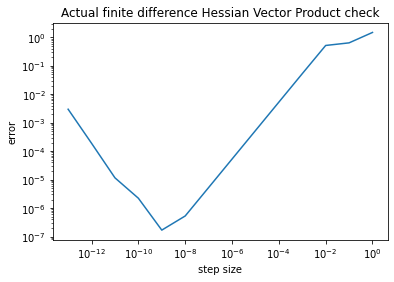

In [35]:
N = 53
alpha = 8.95
L0 = 2.13
u1 = np.random.randn(N)
p = np.random.randn(N)
step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]


# Make log-log plot of gradient finite difference error vs. step size

# Make log-log plot of gradient finite difference error vs. step size
hvp_errs = list()
for s in step_sizes:
    G1 = compute_gradient(u1, alpha, L0)
    u2 = u1 + s*p

    G2 = compute_gradient(u2, alpha, L0)
    Hp_diff = (G2 - G1) / s

    Hp = compute_hessian_vector_product(u1, p, alpha, L0)

    hessian_vector_product_error = np.linalg.norm(Hp - Hp_diff) / np.linalg.norm(Hp_diff)
    
    print('step size=', s, ', Hessian vector product finite difference error=', hessian_vector_product_error)

    hvp_errs.append(hessian_vector_product_error)

plt.loglog(step_sizes, hvp_errs)
plt.title('Actual finite difference Hessian Vector Product check')
plt.xlabel('step size')
plt.ylabel('error')

### Comparison with dense Hessian

The  $N \times N$ Hessian matrix is the Jacobian of the gradient, which can also be computed via automatic differentiation. This is not recommended for large problems.

Here we show how to compute the  Hessian using the Jacobian function in autograd.

In [36]:
compute_hessian = jacobian(compute_gradient, 0)

### Test dense Hessian
Error should be of the order machine epsilon (less than $10^{-14}$)

In [37]:
N = 15
alpha = 8.95
L0 = 2.13
u1 = np.random.randn(N)

H = compute_hessian(u1, alpha, L0)

p = np.random.randn(N)
Hp_dense = np.dot(H, p)
Hp = compute_hessian_vector_product(u1, p, alpha, L0)

dense_hessian_error = np.linalg.norm(Hp_dense - Hp) / np.linalg.norm(Hp)
print('dense_hessian_error=', dense_hessian_error)

dense_hessian_error= 5.452183358094436e-16


# 4) Comparison of optimization methods

In this problem, we will minimize $J$ using the method of steepest descent, BFGS, and the Newton-Conjugate-Gradient method. We will also plot convergence curves, and estimate the rate of convergence for these methods.

We will show you how to do this using BFGS as an example, and you will do this for steepest descent and Newton-CG.

### Problem parameters

For this problem, please use $N=32$, $L_0 = 3.0$, and $\alpha=1e2$.

In [125]:
N = 32
L0 = 3.0
alpha = 1e2

# Useful versions of the objective, gradient, 
# and hessian-vector product functions
J_func = lambda u: objective_function(u, alpha, L0)
g_func = lambda u: compute_gradient(u, alpha, L0)
Hp_func = lambda u, p: compute_hessian_vector_product(u, p, alpha, L0)

### Initial guess

A reasonable initial guess is the parabola
$$u_0(x) = -C x(1-x)$$
with constant 
$$C = 2 \left(L_0 - 1\right).$$
The constant $C$ is chosen to make the arc length of $u$ close to $L_0$. The formula for $C$ can be derived by the sum of the lengths of the left, right, and bottom edges of the box that bounds the parabola.

In [126]:
xx_including_endpoints = np.linspace(0.0, 1.0, N+2)

C = -2.0 * (L0 - 1.0)
u0_including_endpoints = C * xx_including_endpoints * (1.0-xx_including_endpoints)
u0 = u0_including_endpoints[1:-1]

### Example: BFGS

In [127]:
u = u0.copy()
JJ_bfgs = list()
def callback(uk):
    JJ_bfgs.append(J_func(uk))
    
sol = optimize.minimize(J_func, u0, method='BFGS', jac=g_func, callback=callback, tol=1e-6)
print(sol)
    
u = sol.x

      fun: -2.1828846090866403
 hess_inv: array([[ 4.76614309,  4.32921597,  4.50868564, ..., -1.38540055,
        -1.29635647, -0.70594892],
       [ 4.32921597,  7.8336242 ,  6.80731278, ..., -2.12046235,
        -1.95203868, -1.41083079],
       [ 4.50868564,  6.80731278,  8.28272541, ..., -2.02096186,
        -1.69409649, -1.13120152],
       ...,
       [-1.38540055, -2.12046235, -2.02096186, ...,  8.05547285,
         6.53813243,  4.05944663],
       [-1.29635647, -1.95203868, -1.69409649, ...,  6.53813243,
         7.573566  ,  4.70291914],
       [-0.70594892, -1.41083079, -1.13120152, ...,  4.05944663,
         4.70291914,  5.58777352]])
      jac: array([ 7.45418060e-08, -2.99932720e-08, -6.03720791e-08, -9.02942750e-08,
        1.47976609e-08,  1.15480308e-07,  4.82054802e-07, -2.66124608e-07,
        9.74273363e-08,  2.00760671e-07, -1.01914675e-08,  4.94058143e-07,
       -8.00367851e-09,  2.90389738e-07, -6.67694002e-07,  8.53019851e-07,
        9.76693287e-07,  1.8795170

### BFGS: check that solution gradient is small and plot the solution

||g(u)|| / ||g(u_0)||= 2.626689594166103e-08


Text(0, 0.5, 'u(x)')

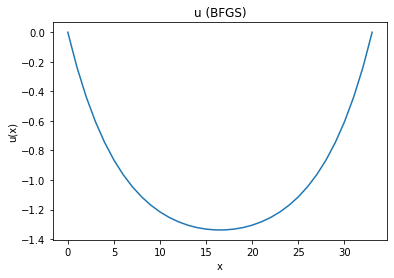

In [128]:
norm_g0 = np.linalg.norm(g_func(u0))
norm_g = np.linalg.norm(g_func(u))
print('||g(u)|| / ||g(u_0)||=', norm_g / norm_g0) # should be less than 1e-6

u_including_endpoints = np.concatenate([[0], u, [0]])

plt.figure()
plt.plot(u_including_endpoints)
plt.title('u (BFGS)')
plt.xlabel('x')
plt.ylabel('u(x)')

### BFGS: Make a convergence plot and estimate convergence rate

Asymptotically, the error should decrease as
$$J(u_{k+1}) - J(u_*) \le c \left(J(u_k) - J(u_*)\right)^q$$
for some constant $c$ and convergence rate $q$, where $u_*$ is the solution to the optimization problem. 

We can estimate the convergence rate, $q$, by plotting $J(u_{k+1}) - J(u_*)$ vs. $J(u_k) - J(u_*)$ on a log-log plot and finding the slope. We use the final value of $J$ as the solution $J(u_*)$. 

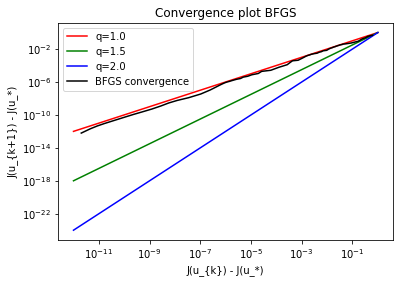

In [129]:
kk = np.logspace(-12, 0, 13)
yy10 = np.power(kk, 1.0)
yy15 = np.power(kk, 1.5)
yy20 = np.power(kk, 2.0)
plt.loglog(kk, yy10, 'r')
plt.loglog(kk, yy15, 'g')
plt.loglog(kk, yy20, 'b')

plt.loglog(JJ_bfgs[:-2] - JJ_bfgs[-1], JJ_bfgs[1:-1] - JJ_bfgs[-1], 'k')
plt.title('Convergence plot BFGS')
plt.ylabel('J(u_{k+1}) - J(u_*)')
plt.xlabel('J(u_{k}) - J(u_*)')
plt.legend(['q=1.0', 'q=1.5', 'q=2.0', 'BFGS convergence'])

## 4a) Steepest descent

The method of steepest descent minimizes the function $J(u)$ via the iteration
$$u_{k+1} = u_k - \beta
_kg(u_k)$$
where $u_k$ is the $k\text{th}$ iterate, $g(u_k)$ is the gradient at the $k\text{th}$ iterate, and $\beta_k$ is a step size parameter.

### Your task:

Minimize $J$ using the method of steepest descent. You should write your own steepest descent code for this (do not use existing steepest descent libraries).

Continue iterating until $||g_k|| < 10^{-6} ||g_0||$ or smaller. This should require several thousand iterations.

Save the function values $J(u_k)$ for all iterations so we can plot the convergence.


#### Hint: step size

The trick here is choosing $\beta_k$. If $\beta_k$ is too large, the method may become unstable and diverge. If $\beta_k$ is too small, the method will converge slowly. 

A popular option is to choose a step length satisfying the Wolfe conditions:

https://en.wikipedia.org/wiki/Wolfe_conditions

You may use the function scipy.optimize.line_search to find a step length satisfying these conditions:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.line_search.html#scipy.optimize.line_search

In [173]:
u = u0.copy() # update u each iteration
J0 = J_func(u)
g0 = g_func(u)
norm_g0 = np.linalg.norm(g0)

JJ_sd = list()
JJ_sd.append(J0) # Keep appending the value of J to this list each iteration

g = g0.copy()
k=0
#print(u,g)
# Solve optimization problem using method of steepest descent. 
while np.linalg.norm(g_func(u))/np.linalg.norm(g0) > 1e-6:
    #calculate step size beta_k using 
    beta_k = optimize.line_search(J_func, g_func, np.array(u), -np.array(g_func(u)))[0]

    #update u
    u = u - beta_k * g_func(u)
    k = k+1
    JJ_sd.append(J_func(u))
    print(k,beta_k,np.linalg.norm(g_func(u))/np.linalg.norm(g0)) 
    
# Now the solution should be in the variable u
# and JJ_sd should be a list, with JJ[k] = J(u_k)

JJ_sd = np.array(JJ_sd) # Make JJ_sd into array instead of list

1 0.008160571336080467 0.8602838546651373
2 0.00276389685761771 0.1302220930414826
3 0.0025568613378211757 0.0016618529752048525
4 0.003298556107840456 0.0008837615639693742
5 0.011685204840756353 0.0016635209453167387
6 0.0032947125189943774 0.0008821011089926081
7 0.01173928985192457 0.0016652088973329745
8 0.003290918655250221 0.0008804696583041331
9 0.011793357575877855 0.00166691703950846
10 0.003287171949274401 0.0008788658775310571
11 0.011847430928492119 0.0016686455931677587
12 0.003283469973884197 0.0008772885038572604
13 0.01190153227761406 0.0016703947925602487
14 0.0032798104322949925 0.0008757363413043106
15 0.011955683488641098 0.001672164884642808
16 0.0032761911493331434 0.000874208256363749
17 0.012009905968430741 0.0016739561289315094
18 0.003272610063258707 0.0008727031739704929
19 0.012064220706423517 0.0016757687973719584
20 0.003269065218264957 0.0008712200737789124
21 0.01211864831383896 0.0016776031742740166
22 0.003265554757506222 0.0008697579867145055
23 0.01

182 0.002982851199660516 0.0007729340111727098
183 0.0204795197237781 0.002026657935243158
184 0.002980234982905752 0.0007719157533944084
185 0.020635683051406586 0.0020325850993560463
186 0.002977623512830494 0.0007708971639066299
187 0.020794618293066842 0.0020386018620770037
188 0.0029750165840036363 0.0007698781303136163
189 0.020956416996364125 0.0020447109104629385
190 0.002972413992592697 0.0007688585395155715
191 0.021121174765397762 0.0020509150418898327
192 0.0029698155361076828 0.0007678382775576027
193 0.021288991504518056 0.0020572171703819317
194 0.0029672210131521546 0.000766817229482985
195 0.02145997167682768 0.0020636203331909258
196 0.0029646302232668137 0.0007657952791745721
197 0.021634224584508997 0.002070127697991398
198 0.002962042966617227 0.0007647723091878446
199 0.02181186467160717 0.002076742570650724
200 0.002959459043809076 0.0007637482005928823
201 0.021993011844015843 0.0020834684033196383
202 0.0029568782556627744 0.0007627228328011327
203 0.0221777918

363 0.017872617439217513 0.001600129928617898
364 0.003373136146568421 0.0006963393516549578
365 0.017177155428764787 0.0015674512927480433
366 0.0034015841370117566 0.0006987104498964892
367 0.016546474098955058 0.0015372251230481766
368 0.0034299231915497323 0.0007010701041110993
369 0.01597137933146772 0.0015091431747551259
370 0.003458182541493384 0.0007034202062137199
371 0.015444377362597728 0.0014829494751300216
372 0.0034863884808276945 0.0007057624862201967
373 0.014959293271004889 0.0014584293301706606
374 0.0035145649218308 0.000708098540641726
375 0.014510988783289097 0.0014354010509097525
376 0.0035427338334044736 0.0007104298552955657
377 0.014095150275921906 0.0014137096344002495
378 0.0035709155916718964 0.0007127578239123392
379 0.013708127261517992 0.0013932218728587085
380 0.0035991292646602607 0.000715083763443724
381 0.013346807780572392 0.0013738225231308093
382 0.003627392845670555 0.0007174089268560794
383 0.013008521142459711 0.0013554112732681622
384 0.0036557

545 0.0050610659833495815 0.0008097272735260454
546 0.0072289855041240665 0.0009710052404277091
547 0.005009614271957023 0.0008051362135340392
548 0.007346928228450828 0.0009783283926154392
549 0.004959724576024511 0.0008006512283369461
550 0.0074677216267492845 0.0009857635894173489
551 0.004911311519878916 0.0007962666610375631
552 0.007591516853805956 0.0009933171259104265
553 0.004864295340816644 0.0007919771762374076
554 0.0077184757772561455 0.0010009956855576458
555 0.004818601394259673 0.0007877777320300839
556 0.007848772019213643 0.0010088063772939614
557 0.0047741597076504895 0.0007836635544048442
558 0.00798259212212871 0.0010167567766705252
559 0.004730904577478991 0.000779630113909129
560 0.00812013685196234 0.0010248549714600341
561 0.004688774204643668 0.0007756731041859661
562 0.0082616226628242 0.001033109612551707
563 0.004647710362835484 0.0007717884222194887
564 0.00840728334475509 0.0010415299707294003
565 0.004607658096918801 0.0007679721500465801
566 0.008557371

722 0.005612523664562575 0.0007488534006579173
723 0.009250677928971952 0.0009679384215022735
724 0.00551171484823252 0.000741185384819031
725 0.009575898357671845 0.0009835540022744864
726 0.005416704984922106 0.0007338480106892071
727 0.009918475172014224 0.0009996971498993628
728 0.005326888144048458 0.0007268062540681506
729 0.010280453351735943 0.0010164325026776955
730 0.0052417314595762385 0.0007200286617284039
731 0.010664209046026121 0.0010338338063867266
732 0.005160763148302959 0.0007134867430349181
733 0.011072523620264837 0.001051985863453942
734 0.0050835626307628706 0.0007071544517545286
735 0.011508678432199628 0.0010709869860161365
736 0.005009752291399322 0.0007010077358550648
737 0.01197657759276426 0.0010909521206650375
738 0.004938990517897485 0.0006950241367648482
739 0.012679122739181448 0.001129750523953633
740 0.004812569989789962 0.0006849711277790571
741 0.013677682120574486 0.0011712737433125715
742 0.004698064269999632 0.0006756275080171654
743 0.0148019309

900 0.01707381934062511 0.0005733505937930776
901 0.02043784839076166 0.0006329560818721029
902 0.016505521883857704 0.0005624284646851121
903 0.021394349870457 0.0006460541237236002
904 0.015983815863639752 0.0005521718610617501
905 0.02242912148005716 0.0006598949157933727
906 0.015501388331714532 0.0005424766099796525
907 0.023556792326860046 0.000674618143701486
908 0.01505220066737035 0.0005332539431565986
909 0.02521665926194396 0.0007022127776719813
910 0.0143465701797546 0.0005191954210072252
911 0.027589594579040467 0.0007322392750557881
912 0.01373184166099871 0.0005065127938580609
913 0.03034634059935683 0.0007655082106739593
914 0.013186261705832985 0.0004948657487125919
915 0.03362766151824181 0.0008031549013783702
916 0.012693684171206582 0.00048398626186376526
917 0.03765179999708765 0.0008468533204930609
918 0.012327962339126605 0.0004769107772828416
919 0.040868747869216834 0.0008792101869399057
920 0.012063868818452943 0.0004702238375718943
921 0.044556662021899125 0.

1085 0.02470461786438218 0.0003670431117805403
1086 0.031987723727584384 0.00041531877542386105
1087 0.025330263272435018 0.00037221931064656215
1088 0.03078218910752205 0.0004064079459625985
1089 0.026182595406363057 0.00037745325770782804
1090 0.029703953005086846 0.0003982433977203146
1091 0.027062563580508854 0.0003827634047139956
1092 0.028731365621924427 0.000390707994459348
1093 0.027974049199886525 0.0003881686434516402
1094 0.027847447473423933 0.00038370790463409035
1095 0.028921281918468517 0.00039368873202342446
1096 0.02703866834590112 0.00037716681796219165
1097 0.029908939850361457 0.000399344719573264
1098 0.026294092991972513 0.0003710218192480051
1099 0.030942262985214013 0.00040515939578889205
1100 0.025604770109960425 0.00036522038086570397
1101 0.032027186399613695 0.0004111577905118867
1102 0.025073994755141094 0.00036131049573589867
1103 0.03279170810383538 0.00041499745688562554
1104 0.024635723618922193 0.0003569416733107499
1105 0.033732506895192076 0.00041984

1266 0.044244131444466296 0.00029814644683879036
1267 0.027039242378131764 0.00023188724361931535
1268 0.04512121879008078 0.00030031308240167107
1269 0.026752674114785175 0.0002300624012711096
1270 0.04603021734924883 0.0003025371915886923
1271 0.02647332542364128 0.00022826513041268278
1272 0.046973536351132605 0.0003048232234913919
1273 0.026200744588953592 0.0002264934276645032
1274 0.04795382862535197 0.00030717602486431833
1275 0.025934507243240385 0.00022474537480703425
1276 0.04897402365716893 0.00030960089129054163
1277 0.02567421361825555 0.00022301912750329744
1278 0.05035245989082955 0.00031407415903862696
1279 0.025258495864727545 0.00022060381764132028
1280 0.052137986655972794 0.00031870389135143807
1281 0.024908376372327685 0.00021866234363618285
1282 0.0536049757910155 0.00032224809100110885
1283 0.02461788887138809 0.00021677996319304242
1284 0.05511989374035953 0.00032583862771825667
1285 0.02434138857656784 0.00021495163784170947
1286 0.05668598943937598 0.000329479

1438 0.06675053340232769 0.0002085047332113172
1439 0.026510678857491435 0.00013154420943155184
1440 0.06533366327594053 0.00020567022895588133
1441 0.026755629426088764 0.00013175941026701007
1442 0.06399963577011729 0.0002029654604857101
1443 0.02700072537212566 0.00013197468018128934
1444 0.06274075808402944 0.00020037968939953303
1445 0.027246093430694545 0.00013219007817701686
1446 0.06155028462427392 0.00019790339291762422
1447 0.027491854452722342 0.00013240566635495406
1448 0.060422273184534074 0.00019552809078351573
1449 0.02773812427377966 0.0001326215094896952
1450 0.05935146680606203 0.000193246201506358
1451 0.02798501446977573 0.00013283767469137768
1452 0.05833319613417958 0.00019105092228241242
1453 0.02823263301589555 0.00013305423114357194
1454 0.05736329818312589 0.00018893612809291218
1455 0.02848108486236758 0.00013327124990714366
1456 0.056438048341442906 0.0001868962863607095
1457 0.02873047245250124 0.00013348880376598519
1458 0.0555541031817511 0.00018492638452

1610 0.03201629500381342 0.00011627579807754503
1611 0.049862795891043483 0.00014513211286406805
1612 0.03188419070080156 0.00011573948228079346
1613 0.050352833342026705 0.00014565537198382616
1614 0.031652217912217576 0.00011502186268991898
1615 0.05098004010972229 0.00014618116909111332
1616 0.031425955932605464 0.00011431465733169553
1617 0.051616866656704403 0.00014670969241038586
1618 0.03120515934227644 0.00011361740783670216
1619 0.05226365433575509 0.00014724113546758395
1620 0.030989596229007915 0.00011292967775797938
1621 0.052920758935267355 0.00014777569750980854
1622 0.030779047237071182 0.00011225105107480112
1623 0.053588551554845175 0.00014831358390770597
1624 0.030573304695547025 0.00011158113078516694
1625 0.054267419572216105 0.00014885500658709853
1626 0.0303721718212877 0.00011091953761999418
1627 0.05495776765968206 0.0001494001844933477
1628 0.030175461979677867 0.00011026590884498754
1629 0.055660018872685936 0.00014994934405748793
1630 0.029982998011318054 0.0

1790 0.021880969897744153 6.599225832245212e-05
1791 0.26842860754414594 0.0002307523117953028
1792 0.021832626186682306 6.533967692132611e-05
1793 0.27858650824903736 0.0002329659302166682
1794 0.021785065227940315 6.467490754365767e-05
1795 0.2895158384679071 0.0002352834673331348
1796 0.021738270340938913 6.399695367943664e-05
1797 0.3013146852103887 0.00023771665000564955
1798 0.021692226429870804 6.330470359564277e-05
1799 0.31409893913162495 0.000240279081690204
1800 0.021646920181877985 6.259690987406244e-05
1801 0.32800657665306965 0.00024298664555383393
1802 0.02160234043636597 6.187216582628838e-05
1803 0.3432032009113811 0.0002458579878190969
1804 0.02155848019640246 6.11289055890076e-05
1805 0.35988804309433775 0.00024891446960822046
1806 0.021515365478386082 6.036591833319043e-05
1807 0.378276404615748 0.0002521669217514213
1808 0.021473591751635414 5.9593309076000094e-05
1809 0.39798009073885404 0.00025529694880885474
1810 0.021445762502725806 5.907751598485427e-05
1811 0

1967 0.22859656287516592 0.00013037417161489137
1968 0.022902755550499344 4.1046061324764785e-05
1969 0.23258915897521518 0.0001305219330934617
1970 0.02287251514161546 4.070973991177882e-05
1971 0.236697556460636 0.00013066723928858954
1972 0.022842661188546182 4.0371679611389236e-05
1973 0.24092707877587782 0.00013081008014173827
1974 0.022813188210860567 4.0031825360372905e-05
1975 0.2452833543979673 0.00013095043637484412
1976 0.02278409157442466 3.9690123713449296e-05
1977 0.24977220025580463 0.00013108823482292035
1978 0.022755370776430785 3.934653939059834e-05
1979 0.254398732641459 0.0001312230633041309
1980 0.02272705022615932 3.900116229674771e-05
1981 0.2591612229429906 0.00013135226956501758
1982 0.02269931655308828 3.865492782245584e-05
1983 0.26400771342687 0.0001314577051792904
1984 0.0226734688862236 3.8314686224541966e-05
1985 0.2685174175763294 0.00013140935702575965
1986 0.022658788432845644 3.803017767780021e-05
1987 0.26954071593346574 0.00013026119115835182
1988 0

2146 0.025474204207990115 2.7202757482760993e-05
2147 0.12680748296648095 6.062734763858155e-05
2148 0.02543236740422816 2.7059719925695193e-05
2149 0.12795618840709153 6.0630486303585096e-05
2150 0.025390557176927887 2.69166844342468e-05
2151 0.12912757257466742 6.063453730087284e-05
2152 0.02534888045016731 2.677364698482694e-05
2153 0.13032008454275995 6.063900690456107e-05
2154 0.025307400856144118 2.6630603636446096e-05
2155 0.13153291812825407 6.064358772167481e-05
2156 0.025266156561811505 2.6487549980332854e-05
2157 0.1327657211875233 6.0648083884277995e-05
2158 0.025225170469098265 2.6344481054317404e-05
2159 0.13401842487879412 6.0652367389434496e-05
2160 0.025184456137368857 2.6201391369579955e-05
2161 0.13529114416280896 6.0656352647844774e-05
2162 0.02514402133419582 2.6058275043173865e-05
2163 0.13658411507523047 6.0659980616615846e-05
2164 0.025103870192676372 2.5915125893767364e-05
2165 0.13789765690112096 6.066320912554145e-05
2166 0.025064004544247967 2.57719375318874

2325 0.15044017759579492 4.2507358299639746e-05
2326 0.025000581837588003 1.7313055769209267e-05
2327 0.14860444754467514 4.2030933290631276e-05
2328 0.025042491925665235 1.723805466380568e-05
2329 0.14767735807359847 4.168724590281209e-05
2330 0.025074507677511876 1.7165377901122273e-05
2331 0.1465851434758772 4.132419203823353e-05
2332 0.025111201614664 1.7094536714026608e-05
2333 0.14537427477104184 4.09488096838048e-05
2334 0.025151179437715887 1.702488735158985e-05
2335 0.14410508474259187 4.056984964463189e-05
2336 0.025192625562801486 1.6955715793955083e-05
2337 0.14284435025368417 4.019669525120866e-05
2338 0.025233518237738273 1.6886342463811623e-05
2339 0.14165610697237738 3.983808155096262e-05
2340 0.025271905487244676 1.68162144032523e-05
2341 0.14059334916871458 3.9500982382041686e-05
2342 0.02530616290658781 1.674495857496539e-05
2343 0.13969281950466306 3.91899560054483e-05
2344 0.02533516254060139 1.667238831302879e-05
2345 0.13897373404287336 3.890704596257949e-05
2346

2500 0.025190934208860375 1.1356649078120505e-05
2501 0.14962833120401228 2.761704709899134e-05
2502 0.02517845471051231 1.1297066049433223e-05
2503 0.15012463438961585 2.752377120339658e-05
2504 0.02516650075873242 1.123778191675274e-05
2505 0.15060405561640128 2.7428706343193295e-05
2506 0.025155169496498427 1.1178826829558203e-05
2507 0.15106235416081915 2.7331510162535368e-05
2508 0.025144577030846257 1.1120236868843747e-05
2509 0.15149443467528853 2.7231774239175868e-05
2510 0.025134862822022295 1.1062055293376159e-05
2511 0.1518941643733433 2.7129010372615846e-05
2512 0.02512619455133888 1.100433382239614e-05
2513 0.15225418434170623 2.7022636575719322e-05
2514 0.025118773734104132 1.09471341395562e-05
2515 0.15256569373808698 2.6911961847353938e-05
2516 0.025112841405937947 1.0890529174581655e-05
2517 0.15281827125371084 2.6796174416553753e-05
2518 0.02510868343158938 1.0834604166270293e-05
2519 0.1529997419655233 2.667433495823449e-05
2520 0.025106634469376082 1.077945702690959

2679 0.145023602933816 1.7468812448004864e-05
2680 0.02546424354122922 7.311886829698863e-06
2681 0.14401176405394375 1.7324065016863836e-05
2682 0.02549550475111797 7.280520229293975e-06
2683 0.14310043902088163 1.7186802516705136e-05
2684 0.0255237026718014 7.248943674214916e-06
2685 0.14230685806880863 1.7057871216632497e-05
2686 0.025548295665333648 7.217105126961645e-06
2687 0.1416389920723114 1.693755264915295e-05
2688 0.02556902383946452 7.184986967066351e-06
2689 0.14109688863273348 1.6825659824670967e-05
2690 0.02558587321483438 7.1525979395922964e-06
2691 0.14067462557437854 1.6721665257810978e-05
2692 0.02559901779439476 7.1199643581572755e-06
2693 0.14036240639582742 1.6624832509408228e-05
2694 0.02560875606514318 7.087122398729018e-06
2695 0.14014838780219058 1.6534327344632413e-05
2696 0.025615453938732664 7.0541121317174225e-06
2697 0.14002010019897035 1.6449301898548266e-05
2698 0.02561949985061066 7.02097343244871e-06
2699 0.13996542151476712 1.63689504373513e-05
2700 

2859 0.1418560203990035 1.1082835032580786e-05
2860 0.025636585485195307 4.702480962110173e-06
2861 0.1415301098465262 1.101783291164929e-05
2862 0.025646654408905543 4.680783485995229e-06
2863 0.14128235889365445 1.0956252343058817e-05
2864 0.025654328589208308 4.659025093939546e-06
2865 0.14110396808367806 1.0897690986493214e-05
2866 0.02565987572990519 4.6372234593531584e-06
2867 0.14098614355081576 1.0841757318289007e-05
2868 0.025663565578972126 4.615395809990244e-06
2869 0.14092052768681254 1.0788086170345064e-05
2870 0.025665655745108703 4.59355813605597e-06
2871 0.1408994701011279 1.0736348065464367e-05
2872 0.025666382776895896 4.5717247627741284e-06
2873 0.14091615584339914 1.0686252696927494e-05
2874 0.025665957860526046 4.5499081974387845e-06
2875 0.14096464688413324 1.0637549624839708e-05
2876 0.025664565588405106 4.528119201297163e-06
2877 0.14103981956190853 1.0590024248699511e-05
2878 0.025662365492702267 4.506366915657665e-06
2879 0.14113731167765892 1.0543495399434967

3036 0.0252911612897796 3.0224410367285308e-06
3037 0.1551277266671721 7.4655971914719225e-06
3038 0.025292316933868405 3.0070518559462526e-06
3039 0.1550859163106508 7.42617010850414e-06
3040 0.0252943725031036 2.9918050455556645e-06
3041 0.15500792563898538 7.3860844858255774e-06
3042 0.025297454714725446 2.976710281768102e-06
3043 0.15488892692749842 7.34524421923313e-06
3044 0.025301700392400085 2.9617778354706826e-06
3045 0.1547238804193335 7.30355119335254e-06
3046 0.025307253446222807 2.9470183304298753e-06
3047 0.15450769287248414 7.26090920988779e-06
3048 0.025314259919102987 2.9324422873458023e-06
3049 0.15423550072366973 7.217230553124531e-06
3050 0.025322861505162664 2.918059652028367e-06
3051 0.15390296806497622 7.1724431215165395e-06
3052 0.0253331850852258 2.9038789224769895e-06
3053 0.15350680464082284 7.126501826793152e-06
3054 0.025345329711676357 2.889906304005169e-06
3055 0.1530452457019474 7.079398795913854e-06
3056 0.025359353470132222 2.8761448590158925e-06
3057 

3212 0.025535381272986418 1.9747193873046295e-06
3213 0.1476920599096823 4.7378061342288465e-06
3214 0.025532435120015944 1.964887544127637e-06
3215 0.14780059243175522 4.716212359942595e-06
3216 0.025529502837160736 1.9550993516743585e-06
3217 0.14790880666286388 4.694696742946394e-06
3218 0.02552658511082992 1.9453547350338964e-06
3219 0.14801663942871499 4.6732582193669295e-06
3220 0.025523682501955237 1.9356535258012273e-06
3221 0.14812410501247802 4.651896857181752e-06
3222 0.02552079436958208 1.925995545005601e-06
3223 0.1482312395162573 4.630613242608277e-06
3224 0.025517920130339596 1.916380651942333e-06
3225 0.14833801810581151 4.609406605479966e-06
3226 0.02551506071027163 1.9068087271937367e-06
3227 0.14844443168898724 4.588276959032577e-06
3228 0.025512215612932158 1.8972795991820973e-06
3229 0.14855049817173044 4.567224404092336e-06
3230 0.02550938462206434 1.8877931215287945e-06
3231 0.14865620938235213 4.546248599584369e-06
3232 0.02550656813026045 1.8783491661927368e-06

3390 0.025372445419068503 1.256251522841122e-06
3391 0.15406947889214961 3.0872567093310603e-06
3392 0.0253764857427865 1.2499660103367202e-06
3393 0.15391569478767622 3.0699621064928527e-06
3394 0.025381206413667014 1.2437351477382876e-06
3395 0.1537362802455989 3.0525197670090148e-06
3396 0.025386658825923766 1.2375604233985812e-06
3397 0.1535297088752985 3.0349199434235635e-06
3398 0.025392889248430573 1.2314432379984242e-06
3399 0.15329460463825373 3.0171545879661383e-06
3400 0.025399939148509524 1.2253847914274092e-06
3401 0.1530299431529048 2.9992196505208032e-06
3402 0.025407838190461437 1.2193858929503246e-06
3403 0.1527352672276225 2.981116510377913e-06
3404 0.025416603152452304 1.2134470072822075e-06
3405 0.15241062081811022 2.962851434115677e-06
3406 0.025426235147258027 1.20756809833402e-06
3407 0.1520568288750828 2.9444387388626156e-06
3408 0.025436715984361185 1.2017486809309121e-06
3409 0.15167530297108503 2.9258978424476876e-06
3410 0.02544800399911005 1.195987463725525

### Test:

||g(u)|| / ||g(u_0)||= 9.980780269456116e-07


Text(0, 0.5, 'u(x)')

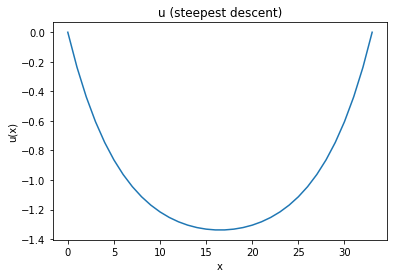

In [174]:
norm_g = np.linalg.norm(g_func(u))
print('||g(u)|| / ||g(u_0)||=', norm_g / norm_g0) # should be less than 1e-6

u_including_endpoints = np.concatenate([[0], u, [0]])

plt.figure()
plt.plot(u_including_endpoints)
plt.title('u (steepest descent)')
plt.xlabel('x')
plt.ylabel('u(x)')

## 4b) Steepest descent convergence

Asymptotically, the error should decrease as
$$J(u_{k+1}) - J(u_*) \le c \left(J(u_k) - J(u_*)\right)^q$$
for some constant $c$ and convergence rate $q$, where $u_*$ is the solution to the optimization problem. 

### Your task:

Estimate the convergence rate, $q$, by plotting $J(u_{k+1}) - J(u_*)$ vs. $J(u_k) - J(u_*)$ on a log-log plot and finding the slope. You may use the final value of $J$ as the solution $J(u_*)$. 

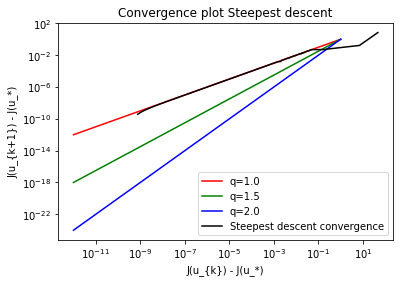

In [176]:
# Make a log-log convergence plot for steepest descent and estimate the convergence rate

kk = np.logspace(-12, 0, 13)
yy10 = np.power(kk, 1.0)
yy15 = np.power(kk, 1.5)
yy20 = np.power(kk, 2.0)
plt.loglog(kk, yy10, 'r')
plt.loglog(kk, yy15, 'g')
plt.loglog(kk, yy20, 'b')

plt.loglog(JJ_sd[:-2] - JJ_sd[-1], JJ_sd[1:-1] - JJ_sd[-1], 'k')
plt.title('Convergence plot Steepest descent')
plt.ylabel('J(u_{k+1}) - J(u_*)')
plt.xlabel('J(u_{k}) - J(u_*)')
plt.legend(['q=1.0', 'q=1.5', 'q=2.0', 'Steepest descent convergence'])

## Order of convergence

The observed convergence rate is the same as the theoretical value $q = 1$.

## 4c) Newton-CG

### Your task:

Minimize $J$ using the Newton-CG method implemented in scipy.optimize.minimize:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

https://docs.scipy.org/doc/scipy/reference/optimize.minimize-newtoncg.html

 - Use a tolerance of $10^{-6}$

 - Save the intermediate values of $J(u_k)$ so that we can study convergence.


### Hint:
To save intermediate values of $J(u_k)$, use a "callback" function.

In [177]:
u = u0.copy()
JJ_ncg = list()
def callback(uk):
    JJ_ncg.append(J_func(uk))

sol = optimize.minimize(J_func, u0, method='Newton-CG', jac=g_func, callback=callback, tol=1e-6)
print(sol)
    
u = sol.x

     fun: -2.182884609087041
     jac: array([-2.31562253e-07, -2.07439462e-07, -3.13453925e-07, -4.60275295e-07,
       -6.62943646e-07, -7.86544917e-07, -1.30876500e-06, -1.60336670e-06,
       -2.23651359e-06, -2.98482693e-06, -3.89722404e-06, -4.93639973e-06,
       -5.95190003e-06, -7.22646756e-06, -8.31747761e-06, -8.25441941e-06,
       -8.57233700e-06, -8.07456720e-06, -7.09013557e-06, -6.03091139e-06,
       -4.96385014e-06, -3.90061840e-06, -3.09726366e-06, -2.25059880e-06,
       -1.65128240e-06, -1.12091559e-06, -8.90978742e-07, -7.21587921e-07,
       -3.76601939e-07, -2.70447678e-07, -3.96906977e-07, -6.57429790e-08])
 message: 'Optimization terminated successfully.'
    nfev: 37
    nhev: 0
     nit: 27
    njev: 736
  status: 0
 success: True
       x: array([-0.23795187, -0.43789424, -0.60578287, -0.74661866, -0.86459672,
       -0.96323116, -1.04546   , -1.11373253, -1.17008242, -1.21618811,
       -1.25342296, -1.28289605, -1.30548532, -1.3218636 , -1.33251874,
     

### Test

||g(u)|| / ||g(u_0)||= 2.380172568775712e-08


Text(0, 0.5, 'u(x)')

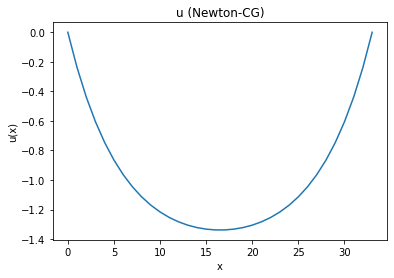

In [178]:
norm_g = np.linalg.norm(g_func(u))
print('||g(u)|| / ||g(u_0)||=', norm_g / norm_g0) # should be less than 1e-6

u_including_endpoints = np.concatenate([[0], u, [0]])

plt.figure()
plt.plot(u_including_endpoints)
plt.title('u (Newton-CG)')
plt.xlabel('x')
plt.ylabel('u(x)')

## 4d) Newton-CG convergence

Asymptotically, the error should decrease as
$$J(u_{k+1}) - J(u_*) \le c \left(J(u_k) - J(u_*)\right)^q$$
for some constant $c$ and convergence rate $q$, where $u_*$ is the solution to the optimization problem. 

### Your task:

Estimate the convergence rate, $q$, for Newton-CG by plotting $J(u_{k+1}) - J(u_*)$ vs. $J(u_k) - J(u_*)$ on a log-log plot and estimating the slope. You may use the final value of $J$ as the solution $J(u_*)$. 

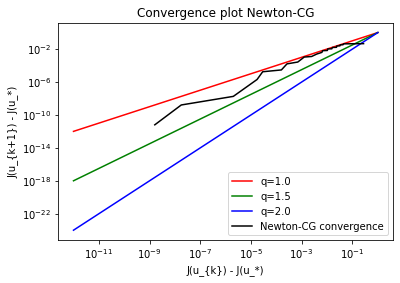

In [180]:
# Make a log-log convergence plot for Newton-CG and estimate the convergence rate

kk = np.logspace(-12, 0, 13)
yy10 = np.power(kk, 1.0)
yy15 = np.power(kk, 1.5)
yy20 = np.power(kk, 2.0)
plt.loglog(kk, yy10, 'r')
plt.loglog(kk, yy15, 'g')
plt.loglog(kk, yy20, 'b')

plt.loglog(JJ_ncg[:-2] - JJ_ncg[-1], JJ_ncg[1:-1] - JJ_ncg[-1], 'k')
plt.title('Convergence plot Newton-CG')
plt.ylabel('J(u_{k+1}) - J(u_*)')
plt.xlabel('J(u_{k}) - J(u_*)')
plt.legend(['q=1.0', 'q=1.5', 'q=2.0', 'Newton-CG convergence'])

## Justification for order of convergence

The observed convergence rate $q$ lies in between $1$ and $1.5$. Therefore the forcing term $\eta_k$ in scipy's implementation of Newton-CG is $\min(0.5,||\textbf{g}_k||^{0.5})$ due to superlinear convergence. Newton-CG has a superlinear convergence whereas steepest descent and BFGS have a linear convergence only. Therefore, Newton-CG is a more efficient choice. Also, the order of convergence profile for Newton-CG is wiggly.

## 5a) Mesh Independence


### Your task:

Find the number of steps to converge $||g(u)|| / ||g(u_0)||<10^{-6}$ for $N+1=\{8,16,32,64,128 \}$ using steepest descent.

In [185]:
C = -2.0 * (L0 - 1.0)
N_array = [7,15,31,63,127]

k_array = []
for N in N_array:
    xx_including_endpoints = np.linspace(0.0, 1.0, N+2)
    u0_including_endpoints = C * xx_including_endpoints * (1.0-xx_including_endpoints)
    u0 = u0_including_endpoints[1:-1]
    u = u0.copy() # update u each iteration
    J0 = J_func(u)
    g0 = g_func(u)
    norm_g0 = np.linalg.norm(g0)

    JJ_sd = list()
    JJ_sd.append(J0) # Keep appending the value of J to this list each iteration

    g = g0.copy()
    k=0
    # Solve optimization problem using method of steepest descent. 
    while np.linalg.norm(g_func(u))/np.linalg.norm(g0) > 1e-6:
        #calculate step size beta_k using 
        beta_k = optimize.line_search(J_func, g_func, np.array(u), -np.array(g_func(u)))[0]
        #update u
        u = u - beta_k * g_func(u)
        k = k+1
        
    print(N+1,k+1)
    k_array.append(k)


8 3401
16 2821
32 3579
64 8467
128 37951


## 5b) Mesh Independence (Newton-CG)


### Your task:

Find the number of steps to converge $||g(u)|| / ||g(u_0)||<10^{-6}$ for $N+1=\{8,16,32,64,128,256 \}$ using Newton-CG.

In [ ]:
C = -2.0 * (L0 - 1.0)
N_array = [7,15,31,63,127]

k_array = []
for N in N_array:
    xx_including_endpoints = np.linspace(0.0, 1.0, N+2)
    u0_including_endpoints = C * xx_including_endpoints * (1.0-xx_including_endpoints)
    u0 = u0_including_endpoints[1:-1]
    u = u0.copy() # update u each iteration
    J0 = J_func(u)
    g0 = g_func(u)
    norm_g0 = np.linalg.norm(g0)

    JJ_sd = list()
    JJ_sd.append(J0) # Keep appending the value of J to this list each iteration

    g = g0.copy()
    k=0
    # Solve optimization problem using method of steepest descent. 
    while np.linalg.norm(g_func(u))/np.linalg.norm(g0) > 1e-6:
        #calculate step size beta_k using 
        beta_k = optimize.line_search(J_func, g_func, np.array(u), -np.array(g_func(u)))[0]
        #update u
        u = u - beta_k * g_func(u)
        k = k+1
        
    print(N+1,k+1)
    k_array.append(k)